In [1]:
!git clone https://github.com/Zafar-Lab/multiHIVE.git

Cloning into 'multiHIVE'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 9), reused 44 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 18.85 KiB | 2.69 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!pip install scvi-tools==0.20.0
!pip install scanpy==1.10.0
!pip install anndata==0.10.6
!pip install scikit-misc

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19877 sha256=3d060789107a75f53b7b42d95fee2a4548c19a015e8b560f00e7014b89a706c0
  Stored in directory: /root/.cache/pip/wheels/06/76/8f/0ecb7d357c0bff71a2bd1940671be2d07a

In [3]:
!pip list | grep scvi  # 0.20.0
!pip list | grep scanpy # 1.10.0
!pip list | grep anndata # 0.10.6

scvi-tools                         0.20.0
scanpy                             1.10.0
anndata                            0.10.6


In [4]:
import scvi
import scanpy as sc
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/content/multiHIVE")
from src.model import HierarVI

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [5]:
adata = scvi.data.pbmcs_10x_cite_seq()

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                                         
Downloading...: 24938it [00:00, 92329.13it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                                          
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 68158.18it/s]


/usr/local/lib/python3.11/dist-packages/scvi/data/_built_in_data/_cite_seq.py:48: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset1.obsm["protein_expression"] = pd.DataFrame(
/usr/local/lib/python3.11/dist-packages/scvi/data/_built_in_data/_cite_seq.py:53: ImplicitModificationWarning: Setting element `.obsm['protein_expression']` of view, initializing view as actual.
  dataset2.obsm["protein_expression"] = pd.DataFrame(
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata

AnnData object with n_obs × n_vars = 10849 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch'
    obsm: 'protein_expression'

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
adata.obs_names_make_unique()


In [8]:
#will automatically detect proteins as missing in a certain batch if the protein has 0 counts
#  for each cell in the batch. In other words, to indicate a protein is missing in a certain batch,
#  please set it to 0 for each cell.
batch = adata.obs.batch.values.ravel()
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(
    adata.obsm["protein_expression"][batch == "PBMC5k"]
)

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
    layer="counts"
)

HierarVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Found batches with missing protein expression                                                             


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



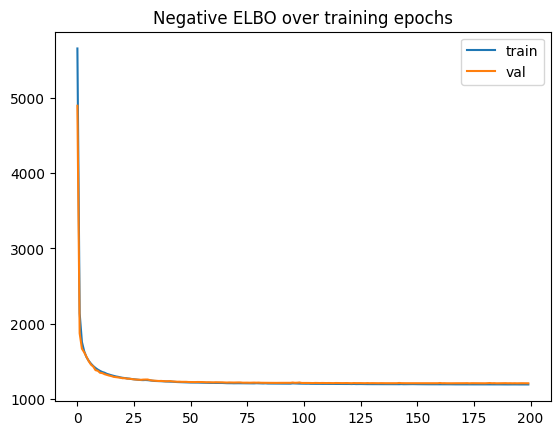

In [13]:
import numpy as np
import matplotlib.pyplot as plt

vae = HierarVI(adata)
vae.train(max_epochs=200)
adata.obsm["Zs1"], adata.obsm["Zs2"], adata.obsm["Zr"], adata.obsm["Zp"] = vae.get_latent_representation()
adata.obsm['Z_multiHIVE'] = np.concatenate((adata.obsm["Zs1"], adata.obsm["Zr"], adata.obsm["Zp"]), axis=1)

plt.plot(vae.history["elbo_train"], label="train")
plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.legend()


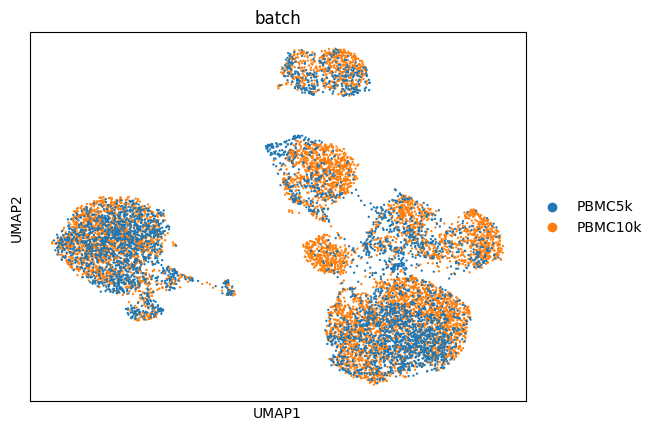

In [12]:
sc.pp.neighbors(adata, use_rep = "Z_multiHIVE")
sc.tl.umap(adata)
sc.pl.umap(adata, color = "batch")

In [15]:
_, protein_means = vae.get_normalized_expression(
    n_samples=25,
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

